<a href="https://colab.research.google.com/github/tkys/faiss_kmeans_spam/blob/master/faiss_k_means_clustering_spam_mail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install faiss-cpu
!pip install faiss-gpu

In [0]:
import time
import numpy as np
import faiss

Loading faiss with AVX2 support.
Loading faiss.


In [0]:
# ベクトル化済みデータ読み取り

# bert-server にて 768次元のベクトル化された文章

import pandas as pd 
df = pd.read_csv('./text_vecs.csv',header=None)

In [0]:
print(df.info())
df.shape

print(df.head(1))

print(df[0][0])
print(df[1][0])
print(df[2][0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Columns: 768 entries, 0 to 767
dtypes: float64(768)
memory usage: 4.7 MB
None
        0         1         2    ...       765       766       767
0 -1.042624 -0.684611  0.235894  ...  0.901826  0.521412 -0.009577

[1 rows x 768 columns]
-1.0426239967346191
-0.684611439704895
0.23589368164539334


In [0]:
dx = df.values.astype('float32') # dataframe→ndarray変換

print(dx.shape)
print(len(df))
print(len(df.columns))

(799, 768)
799
768


In [0]:
# prepare data

d = 768                         # ベクトルの次元(dimension)
nb = len(df)                    # データベースのサイズ(database size) = 今回は入力メールの件数

np.random.seed(1234)
x = np.random.random((nb, d)).astype('float32')

print(x.shape)
x[:, 0] += np.arange(nb) / 1000.


(799, 768)


In [0]:
print(x.shape)
print(x)
x.dtype

(799, 768)
[[0.19151945 0.62210876 0.43772775 ... 0.37387985 0.40151078 0.92509943]
 [0.24585885 0.6640127  0.48122075 ... 0.6033795  0.08225342 0.7098157 ]
 [0.11813839 0.19730248 0.77928543 ... 0.1218152  0.37217978 0.4505319 ]
 ...
 [0.868041   0.51169777 0.47361642 ... 0.8718772  0.7823509  0.71615314]
 [1.1938908  0.69695264 0.9590462  ... 0.23289904 0.14701368 0.9559431 ]
 [1.6404834  0.7540158  0.51185954 ... 0.10693145 0.78597194 0.39644253]]


dtype('float32')

In [0]:
# GPUでの起動

print("BUILD THE INDEX")
res = faiss.StandardGpuResources()
flat_config = faiss.GpuIndexFlatConfig()
index = faiss.GpuIndexFlatL2(res, d, flat_config) 

print(index.is_trained)

BUILD THE INDEX
True


In [0]:
# クラスタリング　Kmeans分類

start = time.time() # 時間計測

ncentroids =  100  # k
niter =  20 
verbose =  True 

#d = x.shape [1]
d = dx.shape [1]

kmeans = faiss.Kmeans(d, ncentroids, niter = niter, verbose = verbose)

#kmeans.train(x)
kmeans.train(np.ascontiguousarray(dx))
#index_sim.add(np.ascontiguousarray(tr_features_np)) # np.ascontiguousarray こちら参考に https://github.com/facebookresearch/faiss/issues/459


train_elapsed_time = time.time() - start # 時間計測
print(train_elapsed_time)

0.20207524299621582


In [0]:
# kの中心点はkmeans.centroids　で取り出す　形見てみる
print(kmeans.centroids.shape)

# k=0　の中心の座標　
print(kmeans.centroids[0])

(100, 768)
[-1.11107804e-01 -1.04132760e+00  1.06809711e+00  7.74233699e-01
  7.83320487e-01  3.12890679e-01  3.52203101e-01  9.62007642e-02
 -9.13880229e-01 -1.22615382e-01  1.37382674e+00 -7.13668227e-01
  2.69753098e-01  5.07965386e-01 -1.53255963e+00 -4.48640525e-01
 -7.78353333e-01 -1.33401394e-01  6.56589210e-01  1.52111247e-01
 -8.68498445e-01  1.79894537e-01 -9.50061738e-01 -1.67364240e-01
  1.62999719e-01  4.26954269e-01 -5.30583203e-01  8.39102507e-01
  3.99853811e-02  5.28581023e-01  1.17651880e+00  6.94781721e-01
 -4.67660725e-01  6.88712299e-01 -2.12926380e-02 -1.84989884e-01
 -2.83250779e-01 -9.17288423e-01 -4.59167391e-01  3.00975621e-01
 -3.20917517e-01  1.11179221e+00 -2.17116401e-01  5.97543903e-02
  1.22845244e+00  4.29216236e-01  8.84425342e-02  4.23888654e-01
 -2.93605834e-01 -3.46292049e-01  2.07462490e-01  4.57980990e-01
 -4.95998353e-01  3.04776192e-01 -1.14708376e+00 -4.85171735e-01
  3.43315303e-01 -4.24556762e-01 -4.23449069e-01  3.05583447e-01
  2.80256957e-

In [0]:
#Assignment
#To compute the mapping from a set of vectors x to the cluster centroids after kmeans has finished training, use:

#割り当て
#kmeansがトレーニングを終了した後、ベクトルxのセットからクラスター重心へのマッピングを計算するには、次を使用します。

#D, I = kmeans.index.search(x, 1)

D, I = kmeans.index.search((np.ascontiguousarray(dx)), 1)


#This will return the nearest centroid for each line vector in x in I. D contains the squared L2 distances.
# 入力xベクトルに関して、最も近い(1)中心座標(nearest centroid)の　indexが　　　　Iに返される
# 入力xベクトルに関して、最も近い(1)中心座標(nearest centroid)の　2乗のL2距離が　Dに返される


In [0]:
print(I.shape)
print(D.shape)

print(I)
print(D)


(799, 1)
(799, 1)
[[15]
 [31]
 [53]
 [53]
 [15]
 [53]
 [53]
 [53]
 [53]
 [53]
 [53]
 [15]
 [53]
 [15]
 [15]
 [15]
 [53]
 [53]
 [15]
 [53]
 [53]
 [15]
 [15]
 [53]
 [15]
 [15]
 [15]
 [15]
 [15]
 [15]
 [15]
 [15]
 [53]
 [25]
 [36]
 [93]
 [45]
 [37]
 [37]
 [25]
 [25]
 [25]
 [93]
 [45]
 [94]
 [45]
 [45]
 [45]
 [45]
 [45]
 [45]
 [31]
 [31]
 [81]
 [94]
 [ 8]
 [ 8]
 [35]
 [ 8]
 [ 8]
 [11]
 [10]
 [51]
 [69]
 [69]
 [47]
 [79]
 [ 3]
 [71]
 [ 8]
 [ 8]
 [ 8]
 [44]
 [27]
 [24]
 [61]
 [35]
 [12]
 [ 6]
 [ 6]
 [55]
 [32]
 [66]
 [42]
 [15]
 [45]
 [42]
 [16]
 [36]
 [45]
 [63]
 [63]
 [95]
 [39]
 [12]
 [96]
 [80]
 [96]
 [41]
 [99]
 [99]
 [99]
 [99]
 [99]
 [64]
 [16]
 [41]
 [83]
 [60]
 [78]
 [63]
 [63]
 [24]
 [ 8]
 [51]
 [ 8]
 [24]
 [87]
 [87]
 [65]
 [65]
 [27]
 [39]
 [43]
 [43]
 [43]
 [43]
 [96]
 [65]
 [57]
 [90]
 [50]
 [57]
 [50]
 [68]
 [90]
 [90]
 [75]
 [55]
 [55]
 [55]
 [55]
 [39]
 [29]
 [29]
 [29]
 [31]
 [31]
 [31]
 [31]
 [31]
 [31]
 [31]
 [31]
 [31]
 [64]
 [64]
 [64]
 [64]
 [80]
 [ 5]
 [31]
 [31]
 [31

In [0]:
for i in I:
  print(I[i],D[i]) #クラスタ番号と中心迄の距離 

[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[81]] [[41.652344]]
[[81]] [[41.652344]]
[[15]] [[0.00024414]]
[[81]] [[41.652344]]
[[81]] [[41.652344]]
[[81]] [[41.652344]]
[[81]] [[41.652344]]
[[81]] [[41.652344]]
[[81]] [[41.652344]]
[[15]] [[0.00024414]]
[[81]] [[41.652344]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[81]] [[41.652344]]
[[81]] [[41.652344]]
[[15]] [[0.00024414]]
[[81]] [[41.652344]]
[[81]] [[41.652344]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[81]] [[41.652344]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[81]] [[41.652344]]
[[15]] [[0.00024414]]
[[45]] [[15.621948]]
[[39]] [[23.936157]]
[[45]] [[15.621948]]
[[37]] [[25.019653]]
[[37]] [[25.019653]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[15]] [[0.00024414]]
[[39]] [[23.936157]]
[[45]] [[15.621948]]
[[12]] [[41.080322]]
[[45]] [[15.621948]]
[[45]] [[15.

In [0]:
# For the reverse operation, eg. to find the 15 nearest points in x to the computed centroids, a new index must be used:
# 逆の操作、例えば。 xで計算された重心に最も近い15個の点を見つけるには、新しいインデックスを使用する必要があります。
# 訓練したオブジェクトkmeansにcentroidsの情報があるので、それを用いればインデクスからcentroidsに最も近い順にIDを取得できます。


index_seek_point = faiss.IndexFlatL2(d)
index_seek_point.add(np.ascontiguousarray(dx))
D, I = index_seek_point.search(kmeans.centroids, 15)

In [0]:
centroid_id = 3
I[centroid_id]

array([402, 401, 403, 225,  67, 683, 227, 755, 332, 504, 175, 174, 179,
       410, 242])

In [0]:
from scipy.spatial.distance import cdist

SSE = (sum(np.min(cdist(dx, kmeans.centroids, 'euclidean'), axis=1)) / dx.shape[0])
SSE

3.111469371944651

In [0]:
import time
import sys

In [0]:
# k means determine k
distortions = [] # 歪みの配列

#K = range(1,len(x))
K = range(1,100) # SSEがすぐ収束するから指定してみる マジデータではkがどうなるか

for k in K:
    start = time.time()
    kmeans = faiss.Kmeans(d, k, niter = niter, verbose = verbose)
    kmeans.train(x)
    train_elapsed_time = time.time() - start
    
    #kmeanModel = KMeans(n_clusters=k,
    #                   init='k-means++',
    #                   n_init = 10,
    #                   max_iter=300,
    #                   random_state=0
    #                   )
    #kmeanModel.fit(X)
    SSE = (sum(np.min(cdist(dx, kmeans.centroids, 'euclidean'), axis=1)) / dx.shape[0])
    distortions.append(SSE)
    print("k:", k, "SSE:", SSE, "elapsed_time:", train_elapsed_time) # クラスタ内歪み（SSE）算出


k: 1 SSE: 32.98448500499338 elapsed_time: 0.05749702453613281
k: 2 SSE: 32.99192780694218 elapsed_time: 0.07229781150817871
k: 3 SSE: 32.970116300238885 elapsed_time: 0.10780048370361328
k: 4 SSE: 32.969493004489564 elapsed_time: 0.10189938545227051
k: 5 SSE: 32.99075546480243 elapsed_time: 0.11556863784790039
k: 6 SSE: 32.98978612870322 elapsed_time: 0.11014080047607422
k: 7 SSE: 32.989448593637924 elapsed_time: 0.12517476081848145
k: 8 SSE: 32.98406306022787 elapsed_time: 0.10652804374694824
k: 9 SSE: 32.95324764834135 elapsed_time: 0.11562442779541016
k: 10 SSE: 32.94198728911427 elapsed_time: 0.12074136734008789
k: 11 SSE: 32.938689542762866 elapsed_time: 0.12633609771728516
k: 12 SSE: 32.938691480068094 elapsed_time: 0.12110543251037598
k: 13 SSE: 32.96189272304543 elapsed_time: 0.1248319149017334
k: 14 SSE: 32.96043157650541 elapsed_time: 0.13280320167541504
k: 15 SSE: 32.95582808663943 elapsed_time: 0.13505220413208008
k: 16 SSE: 32.958883750169655 elapsed_time: 0.12201809883117

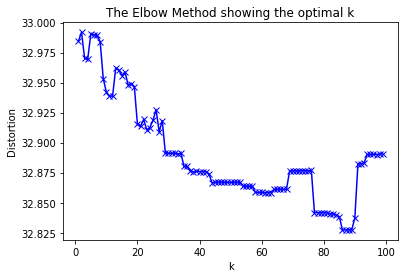

In [0]:
# Plot the elbow　#最適なk探し

import matplotlib.pyplot as plt

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()